# Classification of Land Cover

In [67]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
from rasterio.mask import mask
from rasterio.plot import show, reshape_as_image
from shapely.geometry import mapping
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

เราจะทำการ classify ชนิดของพื้นผิวในภาพ Sentinel-2

## Data preparation

In [2]:
# Find every band
sentinel_dir = "../data/sentinel-2/"
sentinel_band_paths = [os.path.join(sentinel_dir, f)
                       for f in os.listdir(sentinel_dir)
                       if os.path.isfile(os.path.join(sentinel_dir, f))]
sentinel_band_paths.sort()
sentinel_band_paths

['../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B01.tiff',
 '../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B02.tiff',
 '../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B03.tiff',
 '../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B04.tiff',
 '../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B05.tiff',
 '../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B06.tiff',
 '../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B07.tiff',
 '../data/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff']

In [3]:
# We will create the image by stacking all the bands

# Directory to store the image - check to see if it exists, otherwise, create it
img_dir = '../data/products/'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# Path for the image
img_path = img_dir + 'sentinel_bands.tif'

# Get the metadata of each band from the first band (assume all bands have the same metadata)
with rasterio.open(sentinel_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to include the number of layers
meta.update(count=len(sentinel_band_paths))

# Write the image by stacking each band
with rasterio.open(img_path, 'w', **meta) as dst:
    for idx, layer in enumerate(sentinel_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(idx, src1.read(1))

In [4]:
# Read the image and check the number of bands and the dimension
img = rasterio.open(img_path)
img_rows, img_cols = img.shape
img_bands = img.count
print(img_bands, img_rows, img_cols)

8 2201 2629


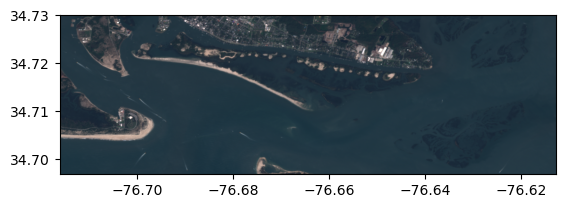

In [7]:
clipped_img = img.read([4, 3, 2])[:, 150:600, 250:1400]  # Clipped composite (432) image
show(clipped_img, transform=img.transform);  # Add the transform argument to get it in (lat, long)

In [8]:
# Check the crs of the image
img.crs

CRS.from_epsg(4326)

We have a shapefile that will be used for training. We will use its "Classname" field as the labels. 

In [10]:
# Open the shapefile and check its crs
shp = gpd.read_file('../data/rcr/rcr_landcover.shp')
shp.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# Reproject the shapefile to (lat, long)
shp = shp.to_crs({'init': 'epsg:4326'})
shp.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
len(shp)

23

In [ ]:
# Get a list of "shapely" geometries
geometry = shp.geometry.values

In [23]:
# Transform the geometry of the first feature in the shapefile to GeoJSON format
feature = [mapping(geometry[0])]  # can also do this using geometry[0].__geo_interface__
feature

[{'type': 'Polygon',
  'coordinates': (((-76.67593927883173, 34.69487548849214),
    (-76.67573882771855, 34.694513199139024),
    (-76.6766693455509, 34.69360077384821),
    (-76.67676946161477, 34.69421769352402),
    (-76.67593927883173, 34.69487548849214)),)}]

In [26]:
# Extract the raster values within the polygon using the "rasterio.mask" function
out_img, out_transform = mask(img, feature, crop=True)
out_img.shape

(8, 18, 13)

In [27]:
# We will be doing a lot of memory-intensive work, so clean up and close this dataset
img.close()

In [29]:
# Prepare the training data

X = np.array([], dtype=np.int8).reshape(0, 8)  # pixels for training
y = np.array([], dtype=np.string_)  # labels for training

# Extract the raster values within the polygon 
with rasterio.open(img_path) as src:
    band_count = src.count
    for idx, geom in enumerate(geometry):
        # A feature
        feature = [mapping(geom)]
        # Get an array of the raster pixels within the feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # Eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:, ~np.all(out_image == 0, axis=0)]
        # Eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:, ~np.all(out_image_trimmed == 255, axis=0)]
        # Reshape the array to (pixel count, bands)
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # Append the labels to the y array
        y = np.append(y, [shp["Classname"][idx]] * out_image_reshaped.shape[0]) 
        # stack the pixels onto the pixel array
        X = np.vstack((X, out_image_reshaped)) 

In [31]:
# Print labels
labels = np.unique(shp["Classname"])
labels

array(['Emergent Wetland', 'Forested Wetland', 'Herbaceous', 'Sand',
       'Subtidal Haline', 'WetSand'], dtype=object)

In [32]:
# Print the size of X and y
print(f"The size of X: {X.shape}")
print(f"The size of y: {y.shape}")

The size of X: (598, 8)
The size of y: (598,)


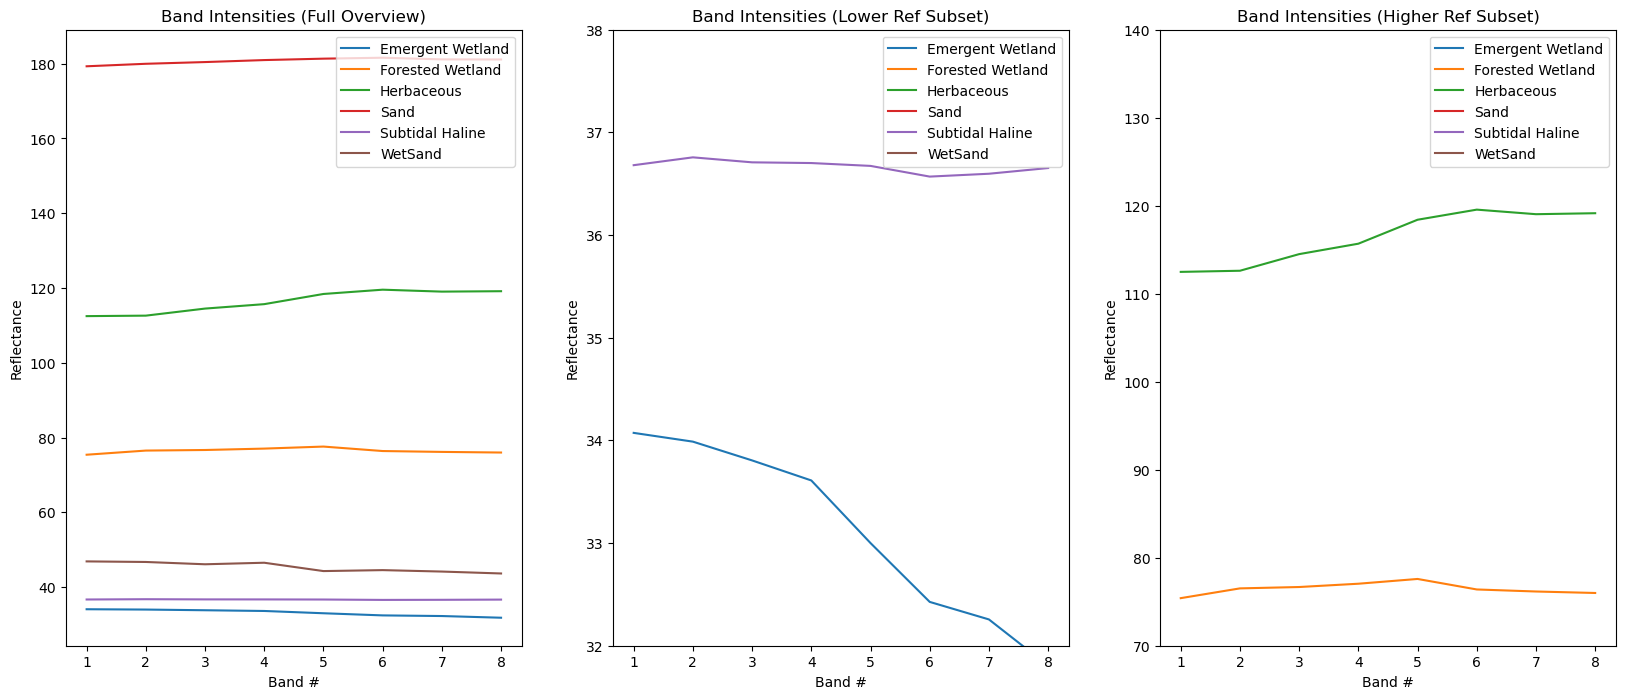

In [37]:
# Explore the spectral signatures of each class
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
band_idx = np.arange(1, 9)  # 1-8
classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y == class_type, :], axis=0)
    axs[0].plot(band_idx, band_intensity, label=class_type)
    axs[1].plot(band_idx, band_intensity, label=class_type)
    axs[2].plot(band_idx, band_intensity, label=class_type)
axs[0].set(title='Band Intensities (Full Overview)', xlabel='Band #', ylabel='Reflectance')
axs[1].set(title='Band Intensities (Lower Ref Subset)', xlabel='Band #', ylabel='Reflectance', ylim=(32, 38))
axs[2].set(title='Band Intensities (Higher Ref Subset)', xlabel='Band #', ylabel='Reflectance', ylim=(70, 140))
axs[0].legend()
axs[1].legend()
axs[2].legend();

In [38]:
# Define a function to convert class labels to indices
def str_class_to_int(class_array):
    class_array[class_array == 'Subtidal Haline'] = 0
    class_array[class_array == 'WetSand'] = 1
    class_array[class_array == 'Emergent Wetland'] = 2
    class_array[class_array == 'Sand'] = 3
    class_array[class_array == 'Herbaceous'] = 4
    class_array[class_array == 'Forested Wetland'] = 5
    return(class_array.astype(int))

## Naive-Bayes classifier

### Training

In [40]:
gnb = GaussianNB().fit(X, y)

### Prediction

In [42]:
with rasterio.open(img_path) as src:
    # Use a part of the image since dealing with the entire image size requires a lot of memory
    img = src.read()[:, 150: 600, 250: 1400]

# Convert raster (bands, rows, cols) into image (rows, cols, bands) for classification
reshaped_img = reshape_as_image(img)

(8, 450, 1150)
(450, 1150, 8)


In [48]:
# Prediction
class_pred = gnb.predict(reshaped_img.reshape(-1, 8))  # Predict
class_pred = class_pred.reshape(reshaped_img[:, :, 0].shape)  # Reshape the prediction map to a 2D array for visualisation
class_pred = str_class_to_int(class_pred)  # Convert class labels to indices

In [50]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# Find the highest pixel value in the prediction image
highest_pred = int(np.max(class_pred))

# Setup a colormap for our map
colors = {
    0: (48, 156, 214, 255),   # Blue - Water
    1: (139, 69, 19, 255),    # Brown - WetSand
    2: (96, 19, 134, 255),    # Purple - Emergent Wetland
    3: (244, 164, 96, 255),   # Tan - Sand
    4: (206, 224, 196, 255),  # Lime - Herbaceous
    5: (34, 139, 34, 255)     # Forest Green - Forest
}
# Normalise 0-255 to 0-1
for k in colors:
    v = colors[k]
    colors[k] = [_v / 255. for _v in v]
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(highest_pred+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', highest_pred+1)

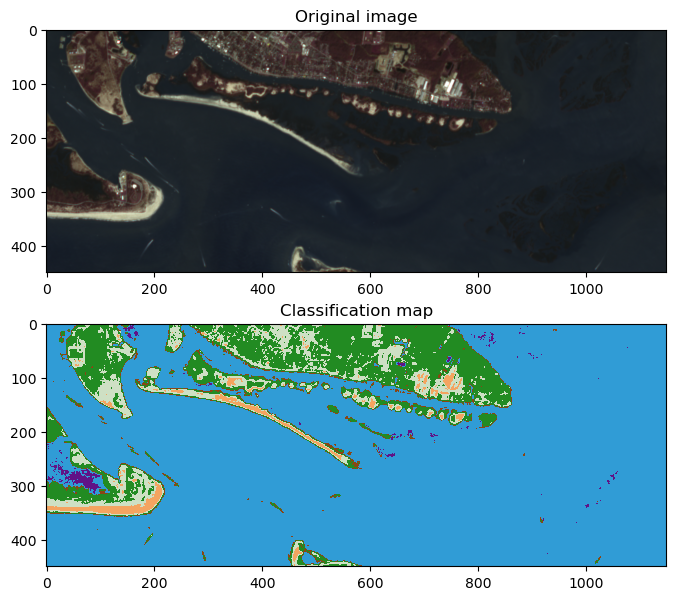

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(8, 7))
img_stretched = color_stretch(reshaped_img, [4, 3, 2])
axs[0].imshow(img_stretched)
axs[0].set_title("Original image")
axs[1].imshow(class_pred, cmap=cmap, interpolation='none')
axs[1].set_title("Classification map");

## K-Means clustering

In [72]:
rows, cols, bands = reshaped_img.shape
kmeans = KMeans(n_clusters=10, random_state=0).fit(reshaped_img.reshape(-1, bands))
class_pred_2d = kmeans.labels_.reshape(rows, cols)

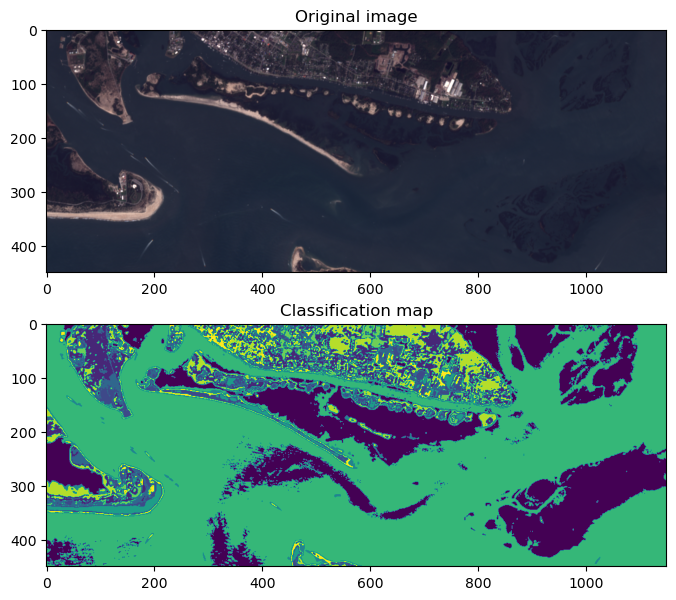

In [74]:
fig, axs = plt.subplots(2, 1, figsize=(8, 7))
img_stretched = color_stretch(reshaped_img, [3, 2, 1])
axs[0].imshow(img_stretched)
axs[0].set_title("Original image")
axs[1].imshow(class_pred_2d)
axs[1].set_title("Classification map");

## Deep learning

See <a href="https://colab.research.google.com/github/patrickcgray/open-geo-tutorial/blob/master/notebooks/chapter_6_neural_networks.ipynb">Google Colab</a>